Dataset is taken from https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs?select=cityscapes_data

In [1]:
import torch
from torch import nn
from torch.nn.functional import leaky_relu
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from func import CustomData, pixel_accuracy, dsc_score, plot_learning_curve, mask2image, plot_masks

In [2]:
class ConvCell(nn.Module):
    
    def __init__(self, in_channels, out_channels, conv_kernel_size, padding, pool_kernel_size, pool_stride, negative_slope):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=conv_kernel_size, padding=padding)
        self.maxpool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.negative_slope = negative_slope

    def forward(self, x):
        x = self.conv(x)
        x = leaky_relu(x, negative_slope=self.negative_slope)
        x = self.maxpool(x)
        return x
        

class Encoder(nn.Module):
    
    def __init__(self, negative_slope):
        super().__init__()
        self.convcell1 = ConvCell(3, 10, (3,3), 'same', (2,2), 2, negative_slope)
        self.convcell2 = ConvCell(10, 20, (3,3), 'same', (2,2), 2, negative_slope)
        self.convcell3 = ConvCell(20, 40, (3,3), 'same', (2,2), 2, negative_slope)
        self.convcell4 = ConvCell(40, 60, (3,3), 'same', (2,2), 2, negative_slope)
        self.convcell5 = ConvCell(60, 80, (3,3), 'same', (2,2), 2, negative_slope)

    def forward(self, x):
        x = self.convcell1(x)
        x = self.convcell2(x)
        x = self.convcell3(x)
        x = self.convcell4(x)
        x = self.convcell5(x)
        return x


class FCN(nn.Module):

    def __init__(self, negative_slope):
        super().__init__()
        self.negative_slope = negative_slope
        self.encoder = Encoder(self.negative_slope)
        self.deconv1 = nn.ConvTranspose2d(80, 100, kernel_size=(3, 3), dilation=4)
        self.deconv2 = nn.ConvTranspose2d(100, 120, kernel_size=(3, 3), dilation=8)
        self.deconv3 = nn.ConvTranspose2d(120, 140, kernel_size=(3, 3), dilation=16)
        self.deconv4 = nn.ConvTranspose2d(140, 160, kernel_size=(3, 3), dilation=32)
        self.deconv5 = nn.ConvTranspose2d(160, 19, kernel_size=(3, 3), dilation=64)

    def forward(self, x):
        x = self.encoder(x)
        x = self.deconv1(x)
        x = leaky_relu(x, negative_slope=self.negative_slope)
        x = self.deconv2(x)
        x = leaky_relu(x, negative_slope=self.negative_slope)
        x = self.deconv3(x)
        x = leaky_relu(x, negative_slope=self.negative_slope)
        x = self.deconv4(x)
        x = leaky_relu(x, negative_slope=self.negative_slope)
        x = self.deconv5(x)
        # x = softmax(x, dim=0) # No softmax because CrossEntropyLoss accepts logits
        return x


In [3]:
dataset_train = CustomData('train')
dataset_valid = CustomData('val')

print(len(dataset_train), len(dataset_valid))

2975 500


In [4]:
batch_size = 32

data_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(data_train, lr, n_epochs, device, seed=None):

    if seed is not None:
        # Set seed for reproducibility
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    model = FCN(negative_slope=0.1)
    model = model.to(device)

    optimizer = Adam(params=model.parameters(), lr=lr)
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    loss_func = nn.CrossEntropyLoss()

    train_loss_lst = []
    valid_loss_lst = []
    train_accuracy_lst = []
    valid_accuracy_lst = []
    train_dsc_lst = []
    valid_dsc_lst = []

    for epoch in range(n_epochs):
        train_loss = 0
        train_acc = 0
        train_dsc = 0
        model.train()
        for x_train, y_train in data_train:

            x_train = x_train.to(device)
            y_train = y_train.to(device)

            predict = model(x_train)
            loss = loss_func(predict, y_train.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()

            train_loss += loss.item()
            train_acc += pixel_accuracy(predict, y_train)
            train_dsc += dsc_score(predict, y_train.long())

        # Take mean of metrics by all batches, add to list for history
        train_loss /= len(data_train)
        train_loss_lst.append(train_loss)
        train_acc /= len(data_train)
        train_accuracy_lst.append(train_acc)
        train_dsc /= len(data_train)
        train_dsc_lst.append(train_dsc)

        # Validation
        valid_loss = 0
        valid_acc = 0
        valid_dsc = 0
        model.eval()
        with torch.no_grad():
            for x_valid, y_valid in data_valid:
                x_valid, y_valid = x_valid.to(device), y_valid.to(device)
                predict = model(x_valid)
                valid_loss += loss_func(predict, y_valid.long()).item()
                valid_acc += pixel_accuracy(predict, y_valid)
                valid_dsc += dsc_score(predict, y_valid.long())

        # Take mean of metrics by all batches, add to list for history
        valid_loss /= len(data_valid)
        valid_loss_lst.append(valid_loss)
        valid_acc /= len(data_valid)
        valid_accuracy_lst.append(valid_acc)
        valid_dsc /= len(data_valid)
        valid_dsc_lst.append(valid_dsc)

        print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}| Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc:.4f}')

    history_loss = dict(
        train_loss=train_loss_lst,
        valid_loss=valid_loss_lst,
    )

    history_accuracy = dict(
        train_accuracy=train_accuracy_lst,
        valid_accuracy=valid_accuracy_lst,
    )

    history_dsc = dict(
        train_dsc=train_dsc_lst,
        valid_dsc=valid_dsc_lst,
    )

    return model, history_loss, history_accuracy, history_dsc

Epoch 1 | Train Loss: 2.9775 | Train Accuracy: 0.4968| Valid Loss: 1.2792 | Valid Accuracy: 0.5604
Epoch 2 | Train Loss: 1.2549 | Train Accuracy: 0.5684| Valid Loss: 1.2561 | Valid Accuracy: 0.5687
Epoch 3 | Train Loss: 1.2400 | Train Accuracy: 0.5720| Valid Loss: 1.2413 | Valid Accuracy: 0.5714


In [ ]:
net, history_loss, history_accuracy, history_dsc = train(data_train, lr=0.01, n_epochs=100, device=device, seed=0)

Epoch 1 | Train Loss: 2.6347 | Train Accuracy: 0.5015| Valid Loss: 1.2777 | Valid Accuracy: 0.5623
Epoch 2 | Train Loss: 1.2529 | Train Accuracy: 0.5702| Valid Loss: 1.2427 | Valid Accuracy: 0.5731
Epoch 3 | Train Loss: 1.2334 | Train Accuracy: 0.5746| Valid Loss: 1.2339 | Valid Accuracy: 0.5720
Epoch 4 | Train Loss: 1.2237 | Train Accuracy: 0.5787| Valid Loss: 1.2298 | Valid Accuracy: 0.5737
Epoch 5 | Train Loss: 1.2176 | Train Accuracy: 0.5811| Valid Loss: 1.2176 | Valid Accuracy: 0.5783
Epoch 6 | Train Loss: 1.2103 | Train Accuracy: 0.5838| Valid Loss: 1.2160 | Valid Accuracy: 0.5818
Epoch 7 | Train Loss: 1.2080 | Train Accuracy: 0.5850| Valid Loss: 1.2091 | Valid Accuracy: 0.5830
Epoch 8 | Train Loss: 1.2035 | Train Accuracy: 0.5869| Valid Loss: 1.2051 | Valid Accuracy: 0.5876
Epoch 9 | Train Loss: 1.1975 | Train Accuracy: 0.5932| Valid Loss: 1.2176 | Valid Accuracy: 0.5886
Epoch 10 | Train Loss: 1.1938 | Train Accuracy: 0.5955| Valid Loss: 1.1955 | Valid Accuracy: 0.5964
Epoch 11 

In [12]:
torch.save(net.state_dict(), 'fcn.tar')

In [ ]:
fig = plot_learning_curve(history_loss)
fig.savefig('learning_curve_loss.png')

In [ ]:
fig = plot_learning_curve(history_accuracy)
fig.savefig('learning_curve_accuracy.png')

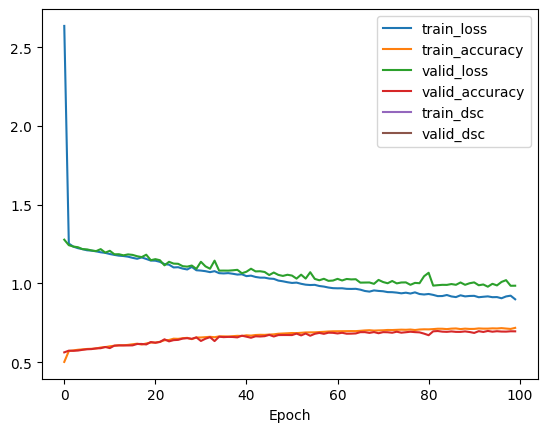

In [ ]:
fig = plot_learning_curve(history_dsc)
fig.savefig('learning_curve_dsc.png')

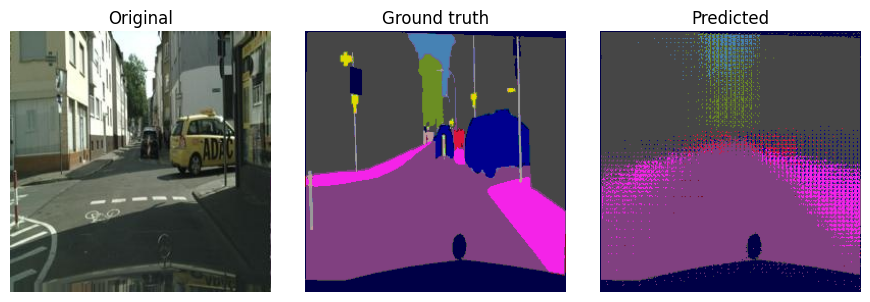

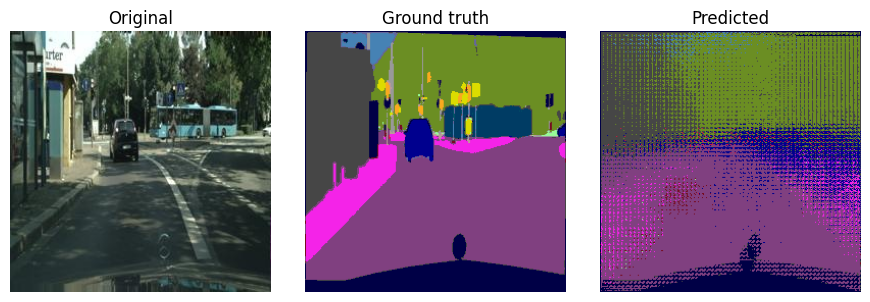

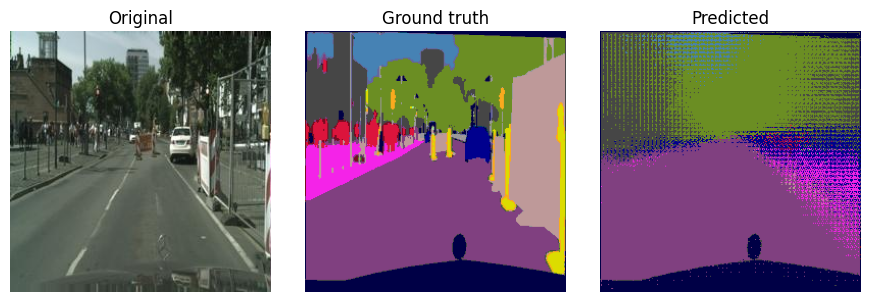

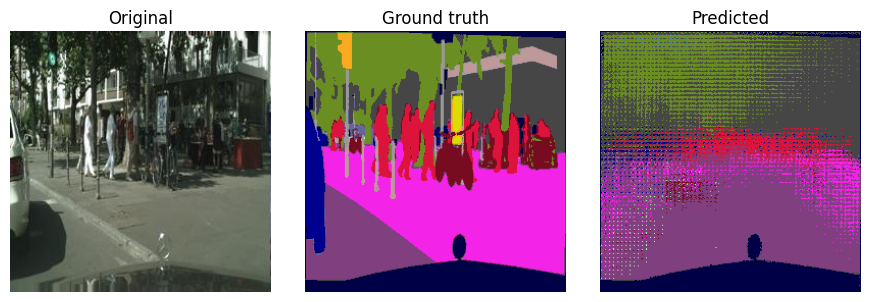

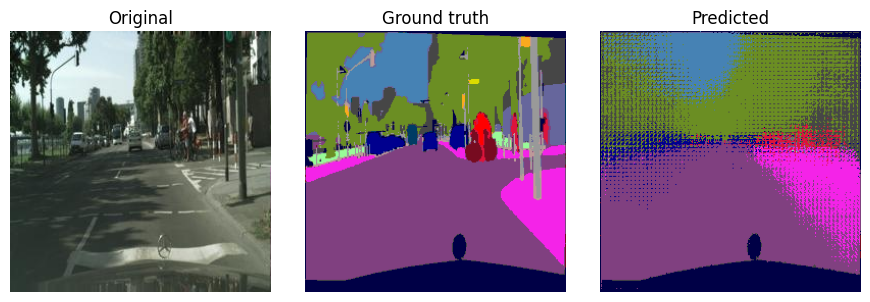

In [41]:
# Plot several images from valid data

for idx in range(5):
    img, target_mask = dataset_valid[idx] # Take image from dataset
    predict = net(img.to(device)) # Make prediction
    predict_mask = predict.argmax(dim=0).to('cpu') # Extract prediction mask

    # Construct images from input and masks
    img_in = img.permute(1, 2, 0)
    img_target = mask2image(target_mask.long())
    img_predict = mask2image(predict_mask)

    # Plot images
    fig = plot_masks(img.permute(1, 2, 0), img_target, img_predict)

In [42]:
fig.savefig('result_example.png')